In [ ]:
import os
import pandas as pd


folder_path = os.path.join("multilayer_logs", "dyn_dt_sweep_0.055_baraffwitkin")
# Create a list to store file info
file_info = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path) as f:
                row_count = sum(1 for _ in f) - 1  # subtract 1 for header
            file_info.append({"filename": filename, "row_count": row_count})
        except Exception as e:
            file_info.append({"filename": filename, "row_count": f"Error: {e}"})



row_counts_df = pd.DataFrame(file_info)

row_counts_df


,filename,row_count
0,avg-sigma.csv,553
1,fillin-pass.csv,2274
2,pcg-resid.csv,2274
3,line-search.csv,2274
4,max-search-dir.csv,2274
5,dyn-consumed.csv,2274
6,toi-recale.csv,2274
7,initialize.csv,1
8,dt.csv,553
9,num-contact.csv,2274


In [ ]:

# around row 641 for csvs with 1107 rows is when dt might have changed 

df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
df['time'] = df['time_or_frame'].copy()
df['newton_steps'] = df['value'].copy()

# calculate the difference between consecutive vid_time values
df['vid_time_diff'] = df['time'].diff()

# find the first index where the increment is (roughly) 0.02
threshold = 0.015  # in case it's slightly off from 0.02 due to float rounding
switch_row = df[df['vid_time_diff'] > threshold].index[0]

# show the row and maybe a few before/after for context
df.iloc[switch_row - 2 : switch_row + 3]
df


,time_or_frame,value,time,newton_steps,vid_time_diff
0,0.000000,3,0.000000,3,NaN
1,0.000227,2,0.000227,2,0.000227
2,0.000507,1,0.000507,1,0.000280
3,0.000694,2,0.000694,2,0.000187
4,0.000883,3,0.000883,3,0.000189
...,...,...,...,...,...
1102,3.968071,1,3.968071,1,0.019976
1103,3.975487,1,3.975487,1,0.007416
1104,3.983251,1,3.983251,1,0.007764
1105,3.990983,1,3.990983,1,0.007732


In [ ]:
# this successfully maps frames to newton steps!!!!



newton_df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
frame_df = pd.read_csv("logs_archive/run_20250505_030057/frame-to-time.csv")
newton_df['time'] = newton_df['time_or_frame'].copy()
newton_df['newton_steps'] = newton_df['value'].copy()
newton_df = newton_df[['time','newton_steps']]

frame_df['frame'] = frame_df['time_or_frame'].copy()
frame_df['time']=frame_df['value'].copy()
frame_df = frame_df[['frame','time']]
frame_df = frame_df.sort_values("time").reset_index(drop=True)


# Merge on the closest matching time using merge_asof
frame_df_sorted = frame_df.sort_values("time")
newton_df_sorted = newton_df.sort_values("time")

# Map time to closest frame time
merged_df = pd.merge_asof(newton_df_sorted, frame_df_sorted, on="time", direction='backward')

# Rename for clarity
merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

# Optional: see the result
merged_df.head()

pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()


,time,newton_steps,corresponding_frame
0,0.000000,3,0
1,0.000227,2,0
2,0.000507,1,0
3,0.000694,2,0
4,0.000883,3,0


In [ ]:
pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()

,time,iterations,newton_steps,corresponding_frame
0,0.000000,262,3,0
1,0.000000,325,3,0
2,0.000000,331,3,0
3,0.000000,166,3,0
4,0.000227,331,2,0


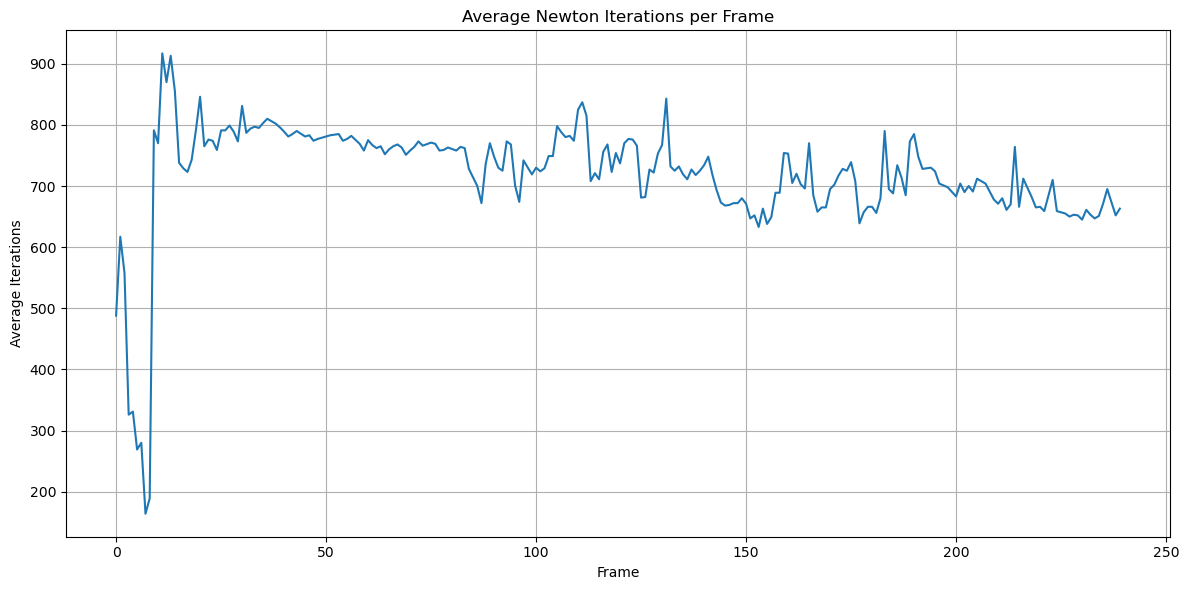

In [15]:
import matplotlib.pyplot as plt

# Group by 'corresponding_frame' and calculate average iterations
avg_iterations_per_frame = merged_df2.groupby('corresponding_frame')['iterations'].max().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_iterations_per_frame['corresponding_frame'], avg_iterations_per_frame['iterations'])
plt.title('Average Newton Iterations per Frame')
plt.xlabel('Frame')
plt.ylabel('Average Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import os
import pandas as pd
import glob


def merge_logs(folder_path):
    """
    Merges newton-steps.csv, frame-to-time.csv, and pcg-iter.csv from a given log folder.
    Returns a DataFrame with time, newton_steps, iterations, and corresponding_frame.
    """
    # Load and preprocess newton-steps
    newton_df = pd.read_csv(os.path.join(folder_path, "newton-steps.csv"))
    newton_df['time'] = newton_df['frame']
    newton_df['newton_steps'] = newton_df['value']
    newton_df = newton_df[['time', 'newton_steps']].sort_values('time')

    # Load and preprocess frame-to-time
    frame_df = pd.read_csv(os.path.join(folder_path, "frame-to-time.csv"))
    # frame_df['frame'] = frame_df['time_or_frame']
    frame_df['time'] = frame_df['value']
    frame_df = frame_df[['frame', 'time']].sort_values('time').reset_index(drop=True)

    # Merge newton steps to frame
    merged_df = pd.merge_asof(newton_df, frame_df, on="time", direction='backward')
    merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

    # Load and preprocess pcg-iter
    pcg_df = pd.read_csv(os.path.join(folder_path, "pcg-iter.csv"))
    pcg_df['time'] = pcg_df['frame']
    pcg_df['iterations'] = pcg_df['value']
    pcg_df = pcg_df[['time', 'iterations']].sort_values('time')

    num_contact = pd.read_csv(os.path.join(folder_path, "num-contact.csv"))
    num_contact['time'] = num_contact['frame']
    num_contact['num_contact'] = num_contact['value']
    num_contact = num_contact[['time', 'num_contact']].sort_values('time')
    # Merge num_contact data
    merged_df = pd.merge_asof(merged_df, num_contact, on="time", direction='backward')

    # Merge pcg data
    final_df = pd.merge_asof(pcg_df, merged_df, on="time", direction='backward')

    return final_df


def read_params_txt(folder_path):
    """Reads params.txt from a folder and returns a dictionary of its values."""
    param_file = os.path.join(folder_path, "params.txt")
    params = {}
    try:
        with open(param_file, "r") as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    # Try converting value to float if possible
                    try:
                        value = float(value)
                    except ValueError:
                        pass
                    params[key] = value
    except FileNotFoundError:
        print(f"No params.txt found in {folder_path}")
    return params

all_dfs = []
fabric_dfs = []
# Iterate over all folders inside fabric_logs
for path in glob.glob("fabric_logs/*"):
    if os.path.isdir(path):
        try:
            df = merge_logs(path)
            df['source_folder'] = os.path.basename(path)

            # Parse params and attach as new columns
            params = read_params_txt(path)
            for key, val in params.items():
                df[key] = val  # broadcast param value to entire DataFrame

            fabric_dfs.append(df)
        except Exception as e:
            print(f"Failed to process {path}: {e}")


# Iterate over all folders inside high_iter
for path in glob.glob("stiff_logs/*"):
    if os.path.isdir(path):
        try:
            df = merge_logs(path)
            df['source_folder'] = os.path.basename(path)

            # Parse params and attach as new columns
            params = read_params_txt(path)
            for key, val in params.items():
                df[key] = val  # broadcast param value to entire DataFrame

            all_dfs.append(df)
        except Exception as e:
            print(f"Failed to process {path}: {e}")


In [8]:
# stiff_combined_df = pd.concat(all_dfs, ignore_index=True)
fabric_combined_df = pd.concat(fabric_dfs, ignore_index=True)

#create fabric column
fabric_combined_df['fabric'] = fabric_combined_df['source_folder'].apply(lambda x: x.split("_")[1])
# all_combined_df.to_csv("all_logs_combined.csv", index=False)
#
fabric_combined_df

,time,iterations,newton_steps,corresponding_frame,num_contact,source_folder,name,dt,dyn_dt_change,strain-limit-eps,bend,area-density,contact-ghat,friction,fabric
0,0.000000,349,2,0,0,fabric_leather_0.047,leather_0.047,0.003,0.047,0.14,50.0,15000.0,0.0003,0.006,leather
1,0.000000,405,2,0,0,fabric_leather_0.047,leather_0.047,0.003,0.047,0.14,50.0,15000.0,0.0003,0.006,leather
2,0.000000,214,2,0,0,fabric_leather_0.047,leather_0.047,0.003,0.047,0.14,50.0,15000.0,0.0003,0.006,leather
3,0.000940,456,2,0,0,fabric_leather_0.047,leather_0.047,0.003,0.047,0.14,50.0,15000.0,0.0003,0.006,leather
4,0.000940,458,2,0,0,fabric_leather_0.047,leather_0.047,0.003,0.047,0.14,50.0,15000.0,0.0003,0.006,leather
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95444,3.990771,719,1,239,10408,fabric_leather_0.035,leather_0.035,0.003,0.035,0.14,50.0,15000.0,0.0003,0.006,leather
95445,3.990771,306,1,239,10408,fabric_leather_0.035,leather_0.035,0.003,0.035,0.14,50.0,15000.0,0.0003,0.006,leather
95446,3.999541,737,2,239,10442,fabric_leather_0.035,leather_0.035,0.003,0.035,0.14,50.0,15000.0,0.0003,0.006,leather
95447,3.999541,730,2,239,10442,fabric_leather_0.035,leather_0.035,0.003,0.035,0.14,50.0,15000.0,0.0003,0.006,leather


In [34]:
#df just for silk
silk_df = fabric_combined_df[fabric_combined_df['source_folder'].str.contains("silk")]

#df just for chiffon
chiffon_df = fabric_combined_df[fabric_combined_df['source_folder'].str.contains("chiffon")]
chiffon_df

,time,iterations,newton_steps,corresponding_frame,num_contact,source_folder,name,dt,dyn_dt_change,strain-limit-eps,bend,area-density,contact-ghat,friction
6669,0.000000,452,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
6670,0.000000,1053,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
6671,0.000000,1070,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
6672,0.000000,611,3,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
6673,0.001082,1182,2,0,0,fabric_chiffon_0.052,chiffon_0.052,0.003,0.052,0.15,0.5,500.0,0.0003,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68383,3.913429,2630,1,234,14587,fabric_chiffon_0.045,chiffon_3,0.003,0.045,0.15,0.5,500.0,0.0003,0.005
68384,3.956588,2339,1,234,14611,fabric_chiffon_0.045,chiffon_3,0.003,0.045,0.15,0.5,500.0,0.0003,0.005
68385,3.956588,1975,1,234,14611,fabric_chiffon_0.045,chiffon_3,0.003,0.045,0.15,0.5,500.0,0.0003,0.005
68386,3.980652,2450,1,237,14656,fabric_chiffon_0.045,chiffon_3,0.003,0.045,0.15,0.5,500.0,0.0003,0.005


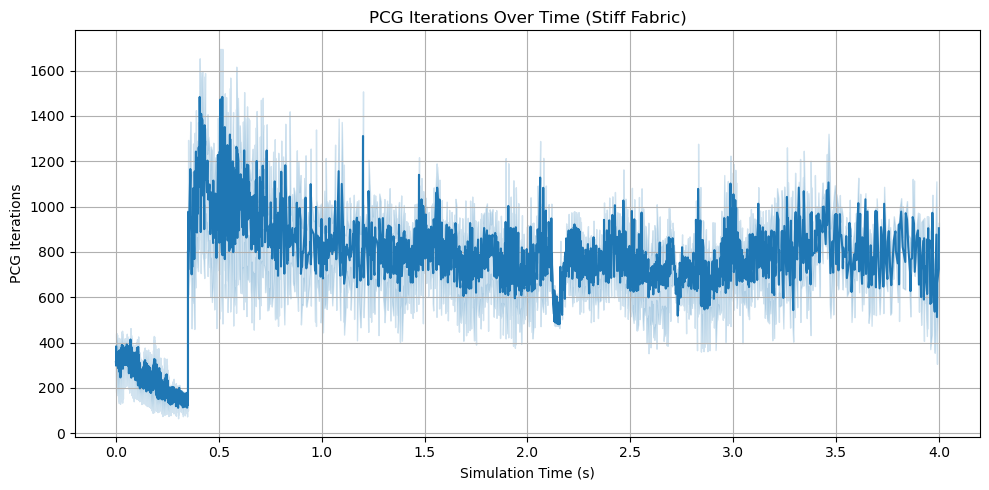

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = stiff_combined_df.copy()
# df = silk_df.copy()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="time", y="iterations")
plt.title("PCG Iterations Over Time (Stiff Fabric)")
plt.xlabel("Simulation Time (s)")
plt.ylabel("PCG Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


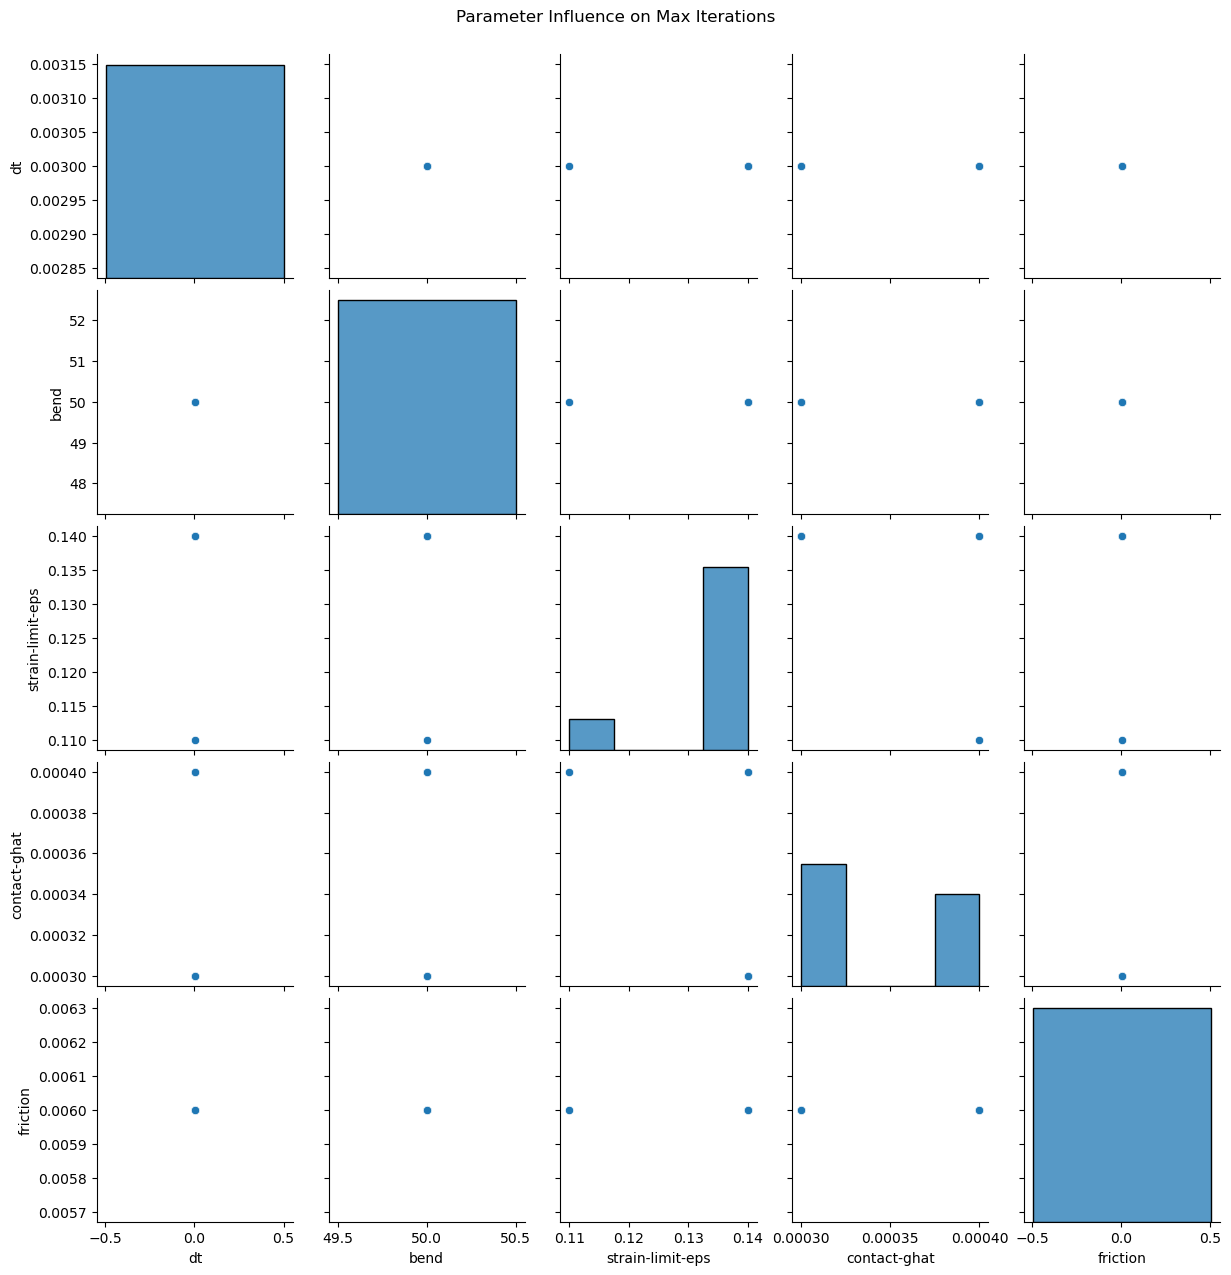

In [2]:
# Get one row per run with max iterations and its associated params
run_summary = pd.DataFrame()
for df in all_dfs:
    summary = df[['iterations']].max().to_frame().T
    summary['source_folder'] = df['source_folder'].iloc[0]

    # Include all parameter columns
    param_cols = [col for col in df.columns if col not in ['time', 'newton_steps', 'iterations', 'corresponding_frame', 'source_folder']]
    for col in param_cols:
        summary[col] = df[col].iloc[0]
    
    run_summary = pd.concat([run_summary, summary], ignore_index=True)

run_summary.head()

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(run_summary, vars=['dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction'], 
             y_vars=['iterations'], height=2.5)
plt.suptitle("Parameter Influence on Max Iterations", y=1.02)
plt.show()



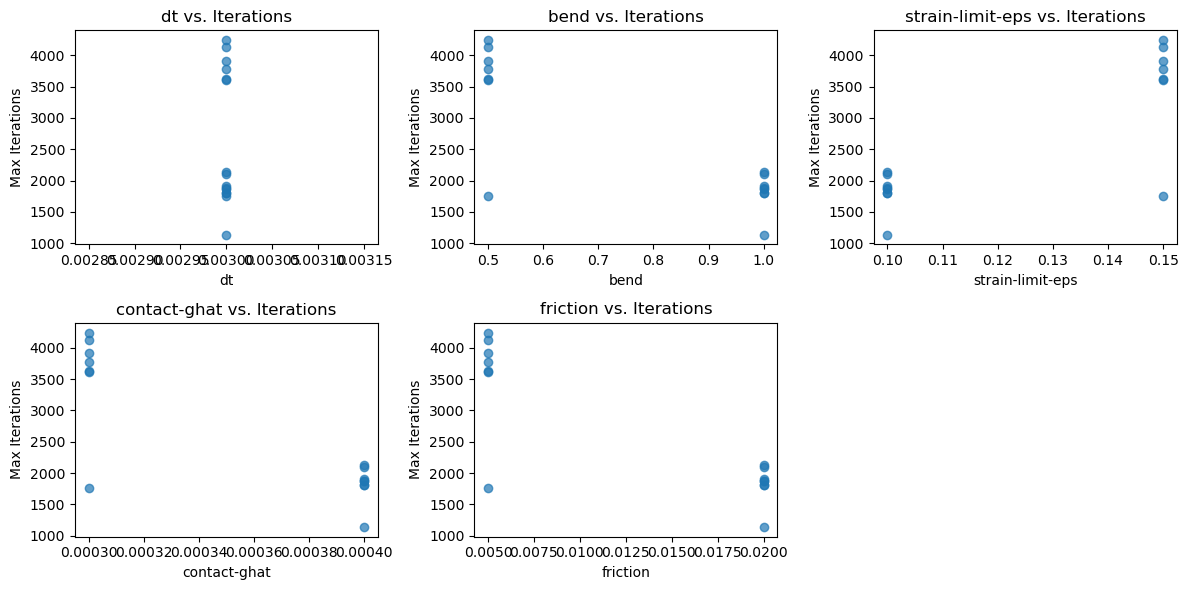

In [14]:
plt.figure(figsize=(12, 6))

for i, param in enumerate(['dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction'], 1):
    plt.subplot(2, 3, i)
    plt.scatter(run_summary[param], run_summary['iterations'], alpha=0.7)
    plt.xlabel(param)
    plt.ylabel('Max Iterations')
    plt.title(f'{param} vs. Iterations')

plt.tight_layout()
plt.show()


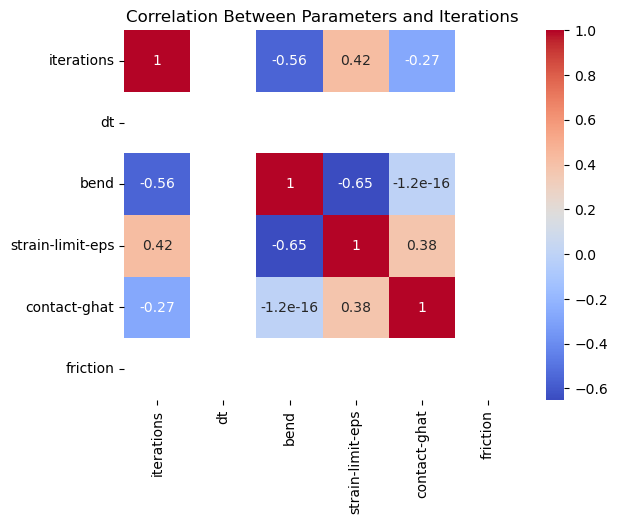

In [12]:
corr = run_summary[['iterations', 'dt', 'bend', 'strain-limit-eps', 'contact-ghat', 'friction']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Parameters and Iterations")
plt.show()


In [13]:
grouped = fabric_combined_df.groupby(['fabric', 'corresponding_frame', 'dyn_dt_change'])['iterations'].max().reset_index()
grouped

,fabric,corresponding_frame,dyn_dt_change,iterations
0,chiffon,0,0.020,848
1,chiffon,0,0.040,1276
2,chiffon,0,0.045,1278
3,chiffon,0,0.047,1302
4,chiffon,0,0.050,1240
...,...,...,...,...
3590,silk,237,0.052,1627
3591,silk,237,0.055,1536
3592,silk,238,0.020,815
3593,silk,238,0.040,1492


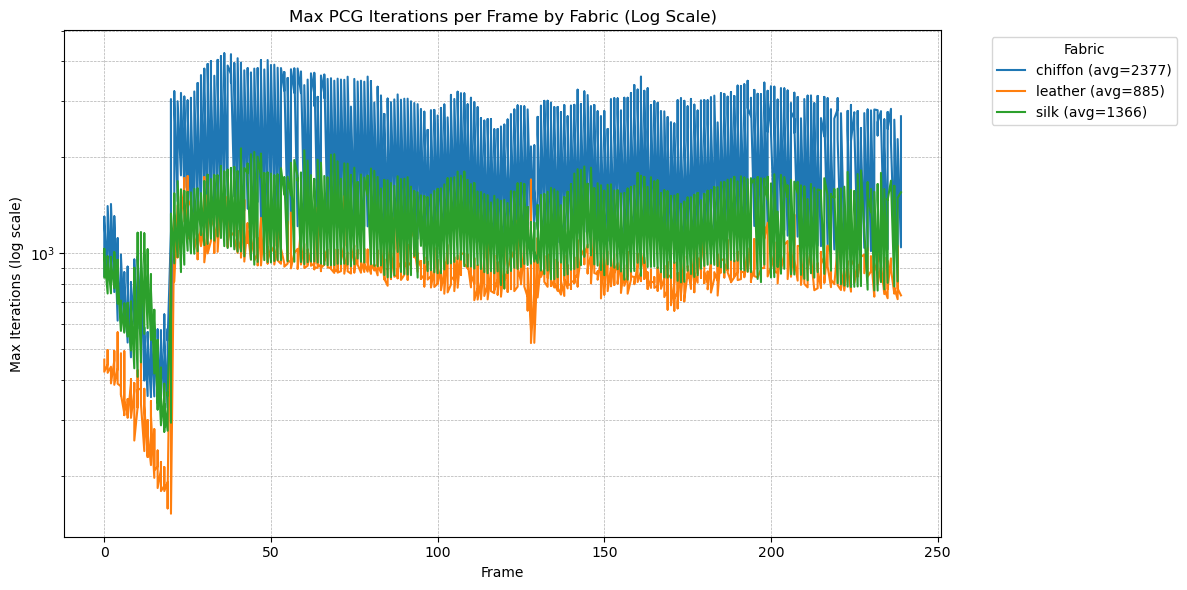

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge 'fabric' column into grouped DataFrame
grouped = fabric_combined_df.groupby(['fabric', 'corresponding_frame', 'dyn_dt_change'])['iterations'].max().reset_index()
# grouped = grouped.merge(
    # fabric_combined_df[['source_folder', 'fabric']].drop_duplicates(),
    # on='source_folder',
    # how='left'
# )
# Calculate average iteration count per fabric
average_iterations = grouped.groupby('fabric')['iterations'].mean()

# Plot setup
plt.figure(figsize=(12, 6))
for fabric_type in grouped['fabric'].unique():
    fabric_data = grouped[grouped['fabric'] == fabric_type]
    plt.plot(
        fabric_data['corresponding_frame'],
        fabric_data['iterations'],
        label=f"{fabric_type} (avg={average_iterations[fabric_type]:.0f})"
    )

# Plot styling
plt.yscale('log')
plt.title("Max PCG Iterations per Frame by Fabric (Log Scale)")
plt.xlabel("Frame")
plt.ylabel("Max Iterations (log scale)")
plt.legend(title="Fabric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


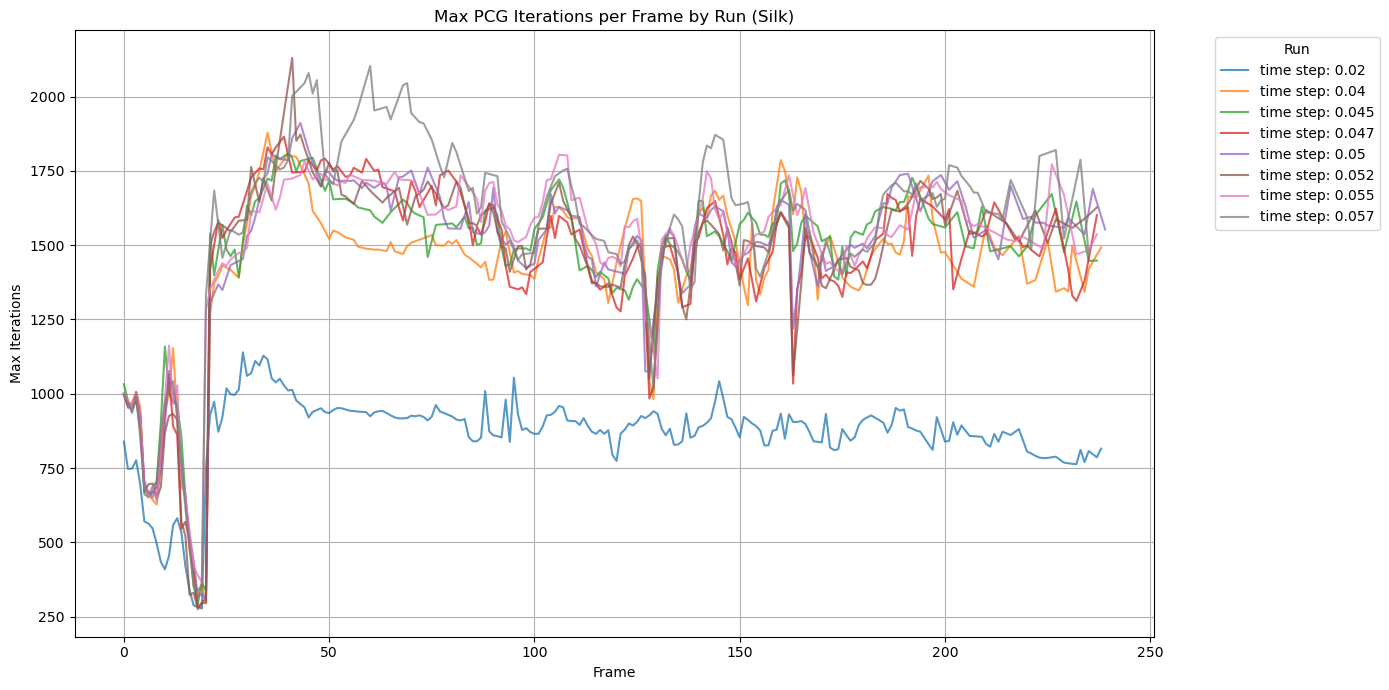

In [45]:
# Make sure the DataFrame includes a 'source_folder' column
# Ensure the DataFrame includes the 'dyn_dt_change' column
# grouped = stiff_combined_df.groupby(['source_folder', 'corresponding_frame', 'dyn_dt_change'])['iterations'].max().reset_index()
grouped = silk_df.groupby(['source_folder', 'corresponding_frame', 'dyn_dt_change'])['iterations'].max().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot each run's max iterations per frame
for run_name in grouped['dyn_dt_change'].unique():
    # Filter data for the current 'dyn_dt_change'
    run_data = grouped[grouped['dyn_dt_change'] == run_name]

    # Plot the data
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=f'time step: {run_name}', alpha=0.75)

plt.title("Max PCG Iterations per Frame by Run (Silk)")
plt.xlabel("Frame")
plt.ylabel("Max Iterations")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



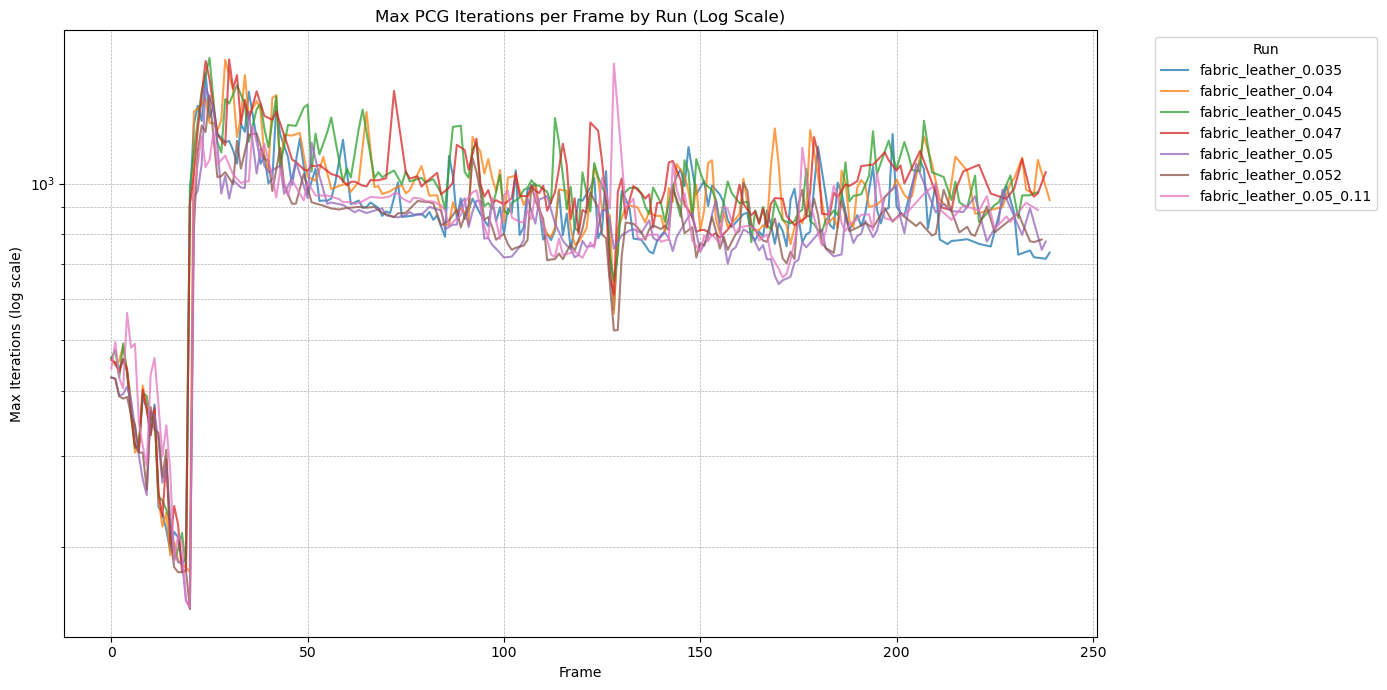

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for run_name in grouped['source_folder'].unique():
    run_data = grouped[grouped['source_folder'] == run_name]
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=run_name, alpha=0.75)

plt.yscale('log')  # log scale
plt.title("Max PCG Iterations per Frame by Run (Log Scale)")
plt.xlabel("Frame")
plt.ylabel("Max Iterations (log scale)")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


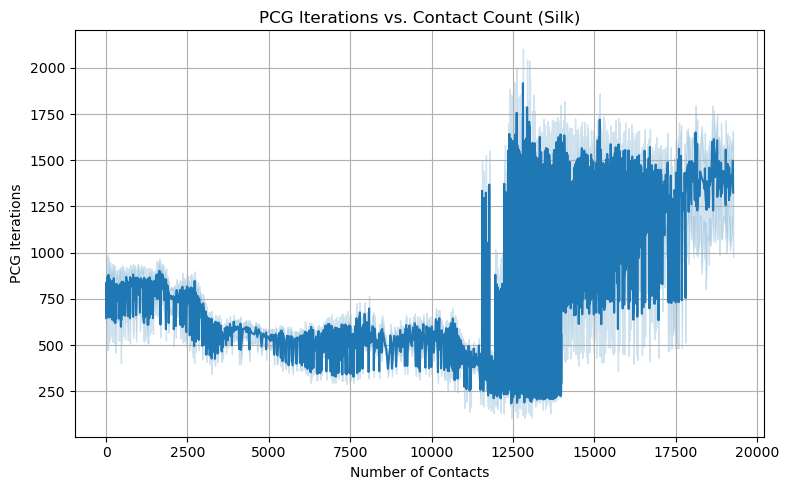

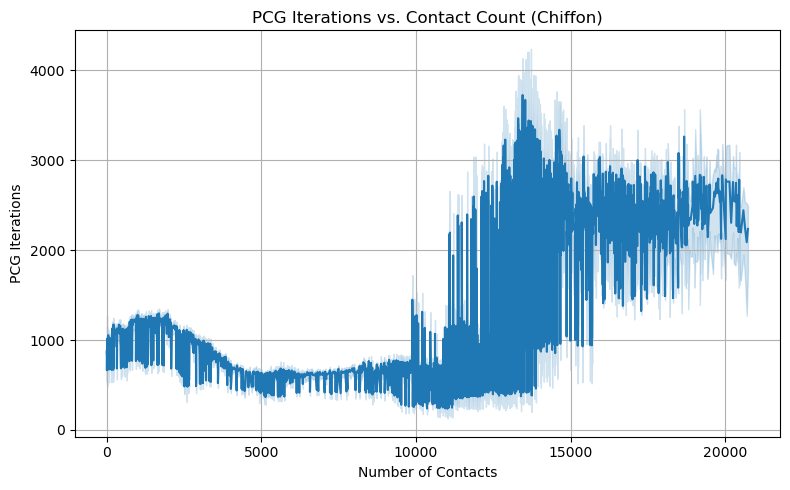

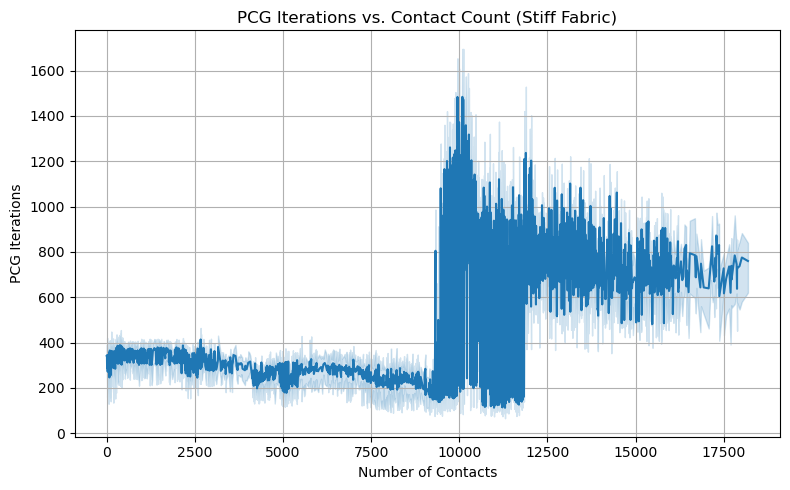

In [48]:


def plot_iter_vs_contact(df, label="Simulation", save_path=None):
    """
    Plots PCG Iterations vs. Number of Contacts from a given DataFrame.

    Parameters:
    - df: pandas DataFrame with 'iterations' and 'num_contact' columns
    - label: Title or label to include in the chart
    - save_path: Optional file path to save the plot (e.g., 'silk_iter_vs_contact.png')
    """
    if "iterations" not in df.columns or "num_contact" not in df.columns:
        raise ValueError("DataFrame must contain 'iterations' and 'num_contact' columns.")
#line plot

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="num_contact", y="iterations")
    plt.title(f"PCG Iterations vs. Contact Count ({label})")
    plt.xlabel("Number of Contacts")
    plt.ylabel("PCG Iterations")
    plt.grid(True)
    plt.tight_layout()


    if save_path:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()
        

    plt.close()


plot_iter_vs_contact(silk_df, label="Silk", save_path="silk_iter_vs_contact.png")
plot_iter_vs_contact(chiffon_df, label="Chiffon", save_path="chiffon_iter_vs_contact.png")
plot_iter_vs_contact(stiff_combined_df, label="Stiff Fabric", save_path="stiff_iter_vs_contact.png")


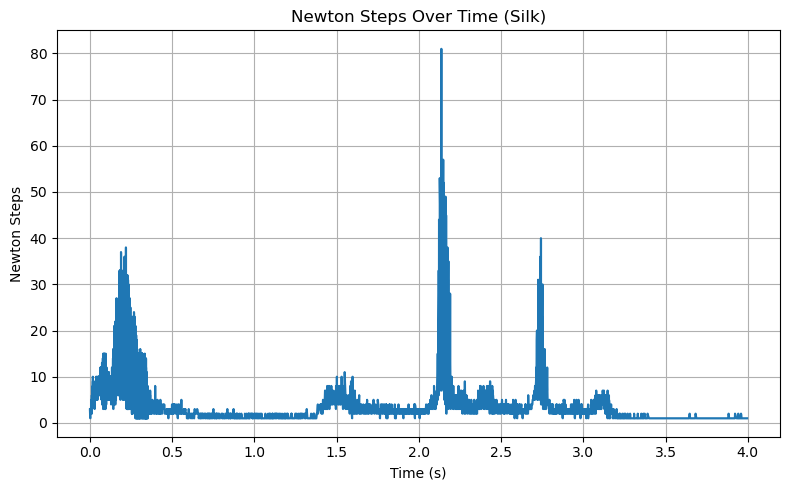

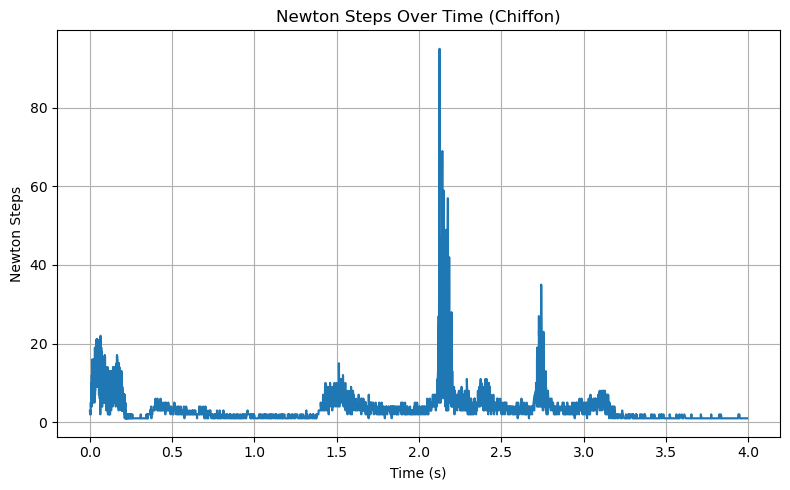

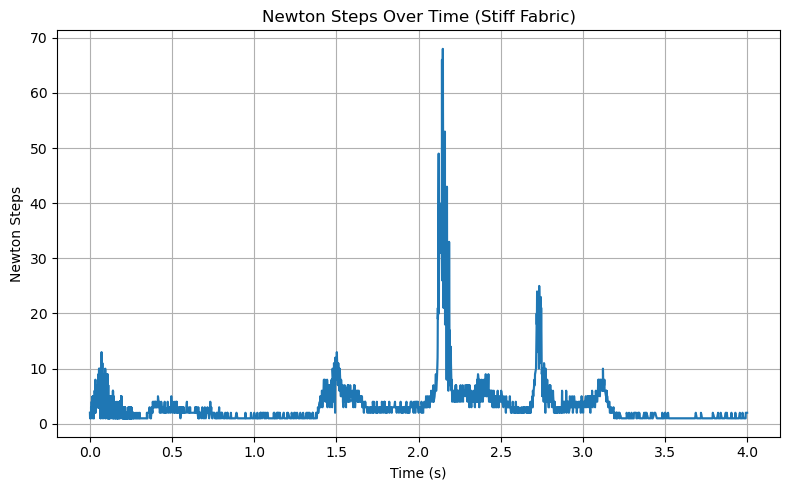

In [50]:
def plot_newton_steps_over_time(df, label="Simulation", save_path=None):
    """
    Plots Newton Steps over Time for a given simulation DataFrame.

    Parameters:
    - df: pandas DataFrame with 'time' and 'newton_steps' columns
    - label: Label for the chart (e.g., 'Silk')
    - save_path: Optional path to save the plot
    """
    if "time" not in df.columns or "newton_steps" not in df.columns:
        raise ValueError("DataFrame must contain 'time' and 'newton_steps' columns.")

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="time", y="newton_steps")
    plt.title(f"Newton Steps Over Time ({label})")
    plt.xlabel("Time (s)")
    plt.ylabel("Newton Steps")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()

    plt.close()

plot_newton_steps_over_time(silk_df, label="Silk", save_path="silk_newton_over_time.png")
plot_newton_steps_over_time(chiffon_df, label="Chiffon", save_path="chiffon_newton_over_time.png")
plot_newton_steps_over_time(stiff_combined_df, label="Stiff Fabric", save_path="stiff_newton_over_time.png")



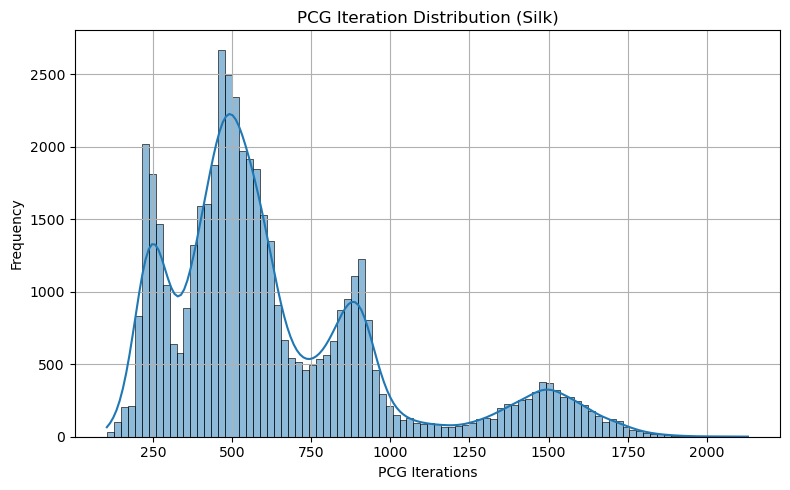

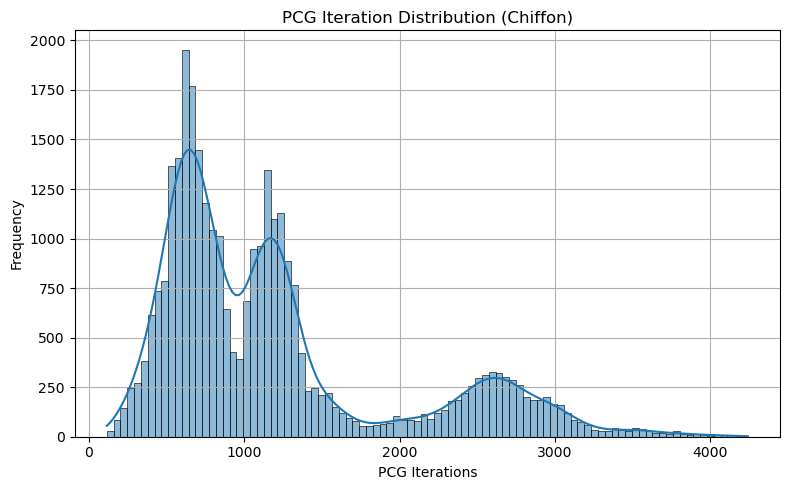

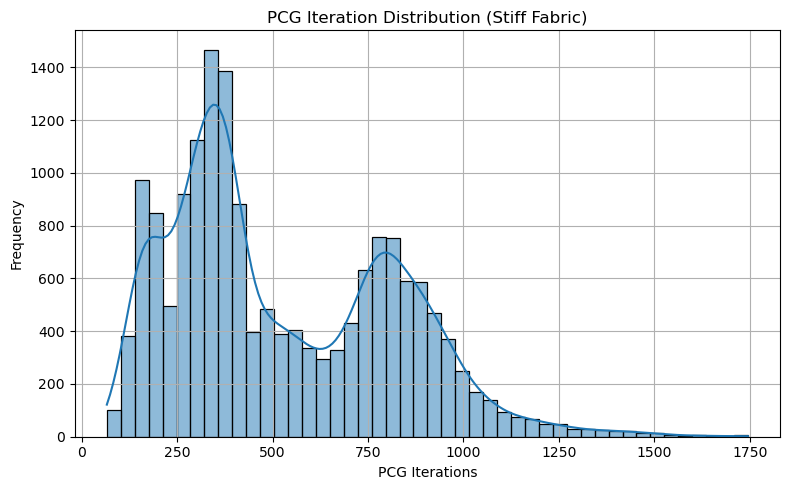

In [ ]:
def plot_iteration_distribution(df, label="Simulation", save_path=None):
    """
    Plots the distribution of PCG Iterations using a histogram or KDE.

    Parameters:
    - df: pandas DataFrame with 'iterations' column
    - label: Chart label (e.g., 'Silk')
    - save_path: Optional path to save the plot
    """
    if "iterations" not in df.columns:
        raise ValueError("DataFrame must contain 'iterations' column.")

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x="iterations", kde=True)
    plt.title(f"PCG Iteration Distribution ({label})")
    plt.xlabel("PCG Iterations")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()

    plt.close()



plot_iteration_distribution(silk_df, label="Silk", save_path="silk_iter_distribution.png")
plot_iteration_distribution(chiffon_df, label="Chiffon", save_path="chiffon_iter_distribution.png")
plot_iteration_distribution(stiff_combined_df, label="Stiff Fabric", save_path="stiff_iter_distribution.png")

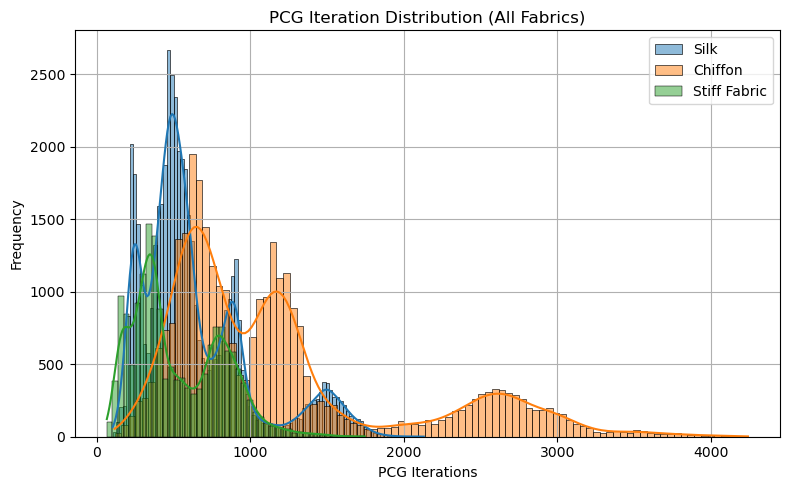

In [52]:
# layered iteration distribution plot of all fabrics

def plot_layered_iteration_distribution(df_list, labels, save_path=None):
    """
    Plots the distribution of PCG Iterations for multiple DataFrames using a histogram or KDE.

    Parameters:
    - df_list: List of pandas DataFrames with 'iterations' column
    - labels: List of labels for each DataFrame
    - save_path: Optional path to save the plot
    """
    if len(df_list) != len(labels):
        raise ValueError("Length of df_list and labels must be the same.")

    plt.figure(figsize=(8, 5))
    
    for df, label in zip(df_list, labels):
        if "iterations" not in df.columns:
            raise ValueError(f"DataFrame for {label} must contain 'iterations' column.")
        sns.histplot(data=df, x="iterations", kde=True, label=label, alpha=0.5)

    plt.title("PCG Iteration Distribution (All Fabrics)")
    plt.xlabel("PCG Iterations")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()

    plt.close()
plot_layered_iteration_distribution(
    [silk_df, chiffon_df, stiff_combined_df],
    ["Silk", "Chiffon", "Stiff Fabric"],
    save_path="layered_iter_distribution.png"
)
# Plotting the distribution of iterations for each fabric type

v: interior for tetrahedral meshes (v)

t: number of tetrahedra
 
f:  number of surface triangles (f) 

Δt: time-step size in seconds

ρ: material density 
 
E: Young’s modulusin units of pascals Pa
 
υ: Poisson’s ratio 
  
ˆd: computational accuracy target in meters , which is set w.r.t. to the scene bounding box diagonal length l

ϵd: Newton Solver tolerance threshold 
 
μ: friction coefficient 
 
ϵv: velocity magnitude bound 
 
#Δt: Total number of time steps (#Δt)



Total time to build/find contact pairs (buildCP); Total time to build energy gradients and Hessians for all types (buildGH); Total linear solver time (solve); Total CCD time
(CCD); Average number of Newton iterations per time step (#i)

In [ ]:
base_experiments = [
    {"name": "strain_sweep_0.15","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.8e-3, "friction": 0.02,},
    {"name": "strain_sweep_0.2","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.2,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "strain_sweep_0.27","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.17,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "friction_high","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.08,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.09,},
    {"name": "dt_large_0.055","dt": 0.002,"dyn_dt_change": 0.055,"bend": 20,"strain-limit-eps": 0.08,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02},
    {"name": "contact_sweep","dt": 0.007,"dyn_dt_change": 0.04,"bend": 5,"strain-limit-eps": 0.02,"area-density":5000, "contact-ghat": 1e-4,"friction": 0.02},
    {"name": "contact_sweep_0.7e-3","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.7e-3,"friction": 0.02,},
    {"name": "contact_sweep_0.6e-3","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.6e-3,"friction": 0.02,},
    {"name": "contact_sweep_0.5e-3","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02,},

    {"name": "strain_sweep_0.08","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.08,"area-density":5000, "contact-ghat": 0.8e-3, "friction": 0.02,},
    {"name": "strain_sweep_0.06","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.06,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "strain_sweep_0.05","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.05,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "friction_sweep_0.05","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.05,},
    {"name": "friction_sweep_0.07","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.07,},
    {"name": "friction_sweep_0.1","dt": 0.002,"dyn_dt_change": 0.037,"bend": 20,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.1,},

    {"name": "dyn_dt_sweep_0.04","dt": 0.002,"dyn_dt_change": 0.04,"bend": 20,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.7e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep_0.045","dt": 0.002,"dyn_dt_change": 0.045,"bend": 20,"strain-limit-eps": 0.2,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep_0.05","dt": 0.002,"dyn_dt_change": 0.05,"bend": 20,"strain-limit-eps": 0.2,"area-density":5000, "contact-ghat": 0.8e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep_0.052","dt": 0.002,"dyn_dt_change": 0.52,"bend": 30,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.6e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep_0.055","dt": 0.002,"dyn_dt_change": 0.055,"bend": 30,"strain-limit-eps": 0.2,"area-density":5000, "contact-ghat": 0.6e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep_0.58","dt": 0.002,"dyn_dt_change": 0.058,"bend": 30,"strain-limit-eps": 0.2,"area-density":5000, "contact-ghat": 0.6e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.06","dt": 0.003,"dyn_dt_change": 0.06,"bend": 20,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.4e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.065","dt": 0.004,"dyn_dt_change": 0.065,"bend": 20,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.68","dt": 0.004,"dyn_dt_change": 0.068,"bend": 20,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.03","dt": 0.004,"dyn_dt_change": 0.04,"bend": 20,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.04","dt": 0.004,"dyn_dt_change": 0.04,"bend": 20,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.2e-3,"friction": 0.02,},
    {"name": "dyn_dt_sweep3_0.45","dt": 0.004,"dyn_dt_change": 0.045,"bend": 20,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.4e-3,"friction": 0.02,},

    {"name": "high_iter1","dt": 0.004,"dyn_dt_change": 0.04,"bend": 25,"strain-limit-eps": 0.12,"area-density":5000, "contact-ghat": 0.4e-3,"friction": 0.02,},
    {"name": "high_iter2","dt": 0.004,"dyn_dt_change": 0.044,"bend": 25,"strain-limit-eps": 0.11,"area-density":5000, "contact-ghat": 0.3e-3,"friction": 0.02,},
    {"name": "high_iter3","dt": 0.004,"dyn_dt_change": 0.045,"bend": 25,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.5e-3,"friction": 0.02,},
    {"name": "high_iter3","dt": 0.004,"dyn_dt_change": 0.047,"bend": 25,"strain-limit-eps": 0.10,"area-density":5000, "contact-ghat": 0.3e-3,"friction": 0.02,},
    {"name": "high_iter4","dt": 0.004,"dyn_dt_chang": 0.048,"bend": 25,"strain-limit-eps": 0.11,"area-density":5000, "contact-ghat": 0.2e-3,"friction": 0.02,},
    {"name": "high_iter5","dt": 0.004,"dyn_dt_change": 0.05,"bend": 35,"strain-limit-eps": 0.099,"area-density":5000, "contact-ghat": 0.3e-3,"friction": 0.02,},
    {"name": "high_iter6","dt": 0.004,"dyn_dt_change": 0.052,"bend": 35,"strain-limit-eps": 0.10,"area-density":5000, "contact-ghat": 0.3e-3,"friction": 0.02,},
    {"name": "high_iter7","dt": 0.004,"dyn_dt_change": 0.055,"bend": 35,"strain-limit-eps": 0.11,"area-density":5000, "contact-ghat": 0.2e-3,"friction": 0.02,},
    {"name": "high_iter8","dt": 0.004,"dyn_dt_change": 0.057,"bend": 35,"strain-limit-eps": 0.099,"area-density":5000, "contact-ghat": 0.2e-3,"friction": 0.02,},
    {"name": "high_iter8","dt": 0.004,"dyn_dt_change": 0.036,"bend": 25,"strain-limit-eps": 0.1,"area-density":5000, "contact-ghat": 0.27e-3,"friction": 0.002,},
    {"name": "high_iter12", "dt": 0.004,"dyn_dt_change": 0.04,"bend": 25,"strain-limit-eps": 0.15,"area-density":5000, "contact-ghat": 0.25e-3,"friction": 0.01,},
    {"name": "high_iter9", "dt": 0.004,"dyn_dt_change": 0.050,"bend": 35,"strain-limit-eps": 0.5,"area-density":5000, "contact-ghat": 0.25e-3,"friction": 0.002,},
    {"name": "high_iter10", "dt": 0.004,"dyn_dt_change": 0.055,"bend": 25,"strain-limit-eps": 0.09,"area-density":5000, "contact-ghat": 0.4e-3,"friction": 0.01,},
    {"name": "high_iter11", "dt": 0.004,"dyn_dt_change": 0.057,"bend": 35,"strain-limit-eps": 0.099,"area-density":5000, "contact-ghat": 0.2e-3,"friction": 0.02,},
]



fabric_experiments = [
   {"name": "silk","dt": 0.003, "dyn_dt_change": 0.04, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
   {"name": "chiffon","dt": 0.003,  "dyn_dt_change": 0.04,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
   {"name": "silk_0.052","dt": 0.003, "dyn_dt_change": 0.052, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
   {"name": "chiffon_0.052","dt": 0.003,  "dyn_dt_change": 0.052,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
   {"name": "silk_0.055","dt": 0.003, "dyn_dt_change": 0.055, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
   {"name": "chiffon_0.055","dt": 0.003,  "dyn_dt_change": 0.055,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
   {"name": "silk_0.057","dt": 0.003, "dyn_dt_change": 0.057, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
   {"name": "chiffon_0.057","dt": 0.003,  "dyn_dt_change": 0.057,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
   {"name": "leather_0.035","dt": 0.003, "dyn_dt_change": 0.035, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
   {"name": "leather_0.04","dt":  0.003, "dyn_dt_change": 0.04, "strain-limit-eps":  0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
   {"name": "leather_0.045","dt": 0.003, "dyn_dt_change": 0.045, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
   {"name": "leather_0.047","dt": 0.003, "dyn_dt_change": 0.047, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
   {"name": "leather_0.05","dt":  0.003, "dyn_dt_change": 0.05, "strain-limit-eps":  0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
   {"name": "leather_0.055","dt": 0.003, "dyn_dt_change": 0.055, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
]




#silk: ran pretty slow but no high convergence. did look like silk. 


fabric_params_df = pd.DataFrame(fabric_experiments)
params_df = pd.DataFrame(base_experiments)
params_df["area-density"] = 5000
params_df = pd.concat([params_df, fabric_params_df], ignore_index=True)
# Display the DataFrame
print(params_df)


params_df.to_csv("simulation_parameters.csv", index=False)

                    name     dt  dyn_dt_change  bend  strain-limit-eps  \
0      strain_sweep_0.15  0.002          0.037  20.0             0.150   
1       strain_sweep_0.2  0.002          0.037  20.0             0.200   
2      strain_sweep_0.27  0.002          0.037  20.0             0.170   
3          friction_high  0.002          0.037  20.0             0.080   
4         dt_large_0.055  0.002          0.055  20.0             0.080   
5          contact_sweep  0.007          0.040   5.0             0.020   
6   contact_sweep_0.7e-3  0.002          0.037  20.0             0.100   
7   contact_sweep_0.6e-3  0.002          0.037  20.0             0.100   
8   contact_sweep_0.5e-3  0.002          0.037  20.0             0.100   
9      strain_sweep_0.08  0.002          0.037  20.0             0.080   
10     strain_sweep_0.06  0.002          0.037  20.0             0.060   
11     strain_sweep_0.05  0.002          0.037  20.0             0.050   
12   friction_sweep_0.05  0.002       

In [ ]:
fabric_experiments = [
    {"name": "silk","dt": 0.003, "dyn_dt_change": 0.04, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
    {"name": "chiffon","dt": 0.003,  "dyn_dt_change": 0.04,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
    {"name": "silk_0.052","dt": 0.003, "dyn_dt_change": 0.052, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
    {"name": "chiffon_0.052","dt": 0.003,  "dyn_dt_change": 0.052,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
    {"name": "silk_0.055","dt": 0.003, "dyn_dt_change": 0.055, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
    {"name": "chiffon_0.055","dt": 0.003,  "dyn_dt_change": 0.055,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
    {"name": "silk_0.057","dt": 0.003, "dyn_dt_change": 0.057, "strain-limit-eps": 0.1, "bend": 1, "area-density": 1000, "contact-ghat": 0.0004, "friction": 0.02},
    {"name": "chiffon_0.057","dt": 0.003,  "dyn_dt_change": 0.057,"strain-limit-eps": 0.15, "bend": 0.5, "area-density": 500, "contact-ghat": 0.0003, "friction": 0.005},
    {"name": "leather_0.035","dt": 0.003, "dyn_dt_change": 0.035, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
    {"name": "leather_0.04","dt":  0.003, "dyn_dt_change": 0.04, "strain-limit-eps":  0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
    {"name": "leather_0.045","dt": 0.003, "dyn_dt_change": 0.045, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
    {"name": "leather_0.047","dt": 0.003, "dyn_dt_change": 0.047, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
    {"name": "leather_0.05","dt":  0.003, "dyn_dt_change": 0.05, "strain-limit-eps":  0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
    {"name": "leather_0.055","dt": 0.003, "dyn_dt_change": 0.055, "strain-limit-eps": 0.1, "bend": 50, "area-density": 15000, "contact-ghat": 0.0003, "friction": 0.006},
]